In [1]:
import pandas as pd
import pickle 
import numpy as np
import datetime as dt
### Read the dataFile 
Read = pickle.load( open( "uke_eggedal_data_challenge.pkl", "rb" ) )

#save data on my variable
data  = {}
for ids,sets in Read.items():
    data[ids] = sets

#Check keys and data types in the  dic
for ids,sets in data.items():
    print(ids, f', Dtype = {type(sets)}, Total values in Set:{len(sets)}')

flow , Dtype = <class 'numpy.ndarray'>, Total values in Set:21542
obs_tas , Dtype = <class 'numpy.ndarray'>, Total values in Set:21546
flow_dates , Dtype = <class 'pandas.core.series.Series'>, Total values in Set:21542
obs_lon_lat , Dtype = <class 'list'>, Total values in Set:2
obs_pr , Dtype = <class 'numpy.ndarray'>, Total values in Set:21546
obs_dates , Dtype = <class 'pandas.core.series.Series'>, Total values in Set:21546


In [2]:
#Separate the obs_tas and obs_pr arrays into individual columns to make things easier to see
Temp = {}
precipitation ={}

#create dummy data for dictionary depending on lenght of values 
for i in data['obs_pr']:
    Length = len(i)
    for j in range (Length):
        precipitation[f'Prec_Zone_{j}'] = []
#Fill the empty list with the corresponding data 
index = 0
for ids,val in precipitation.items():
    for i in data['obs_pr']:
        precipitation[ids].insert(index,i[index])
    index = index+1    
dfprecipitation = pd.DataFrame(precipitation)

In [3]:
# Repeat for Temperature

#create dummy data for dictionary depending on lenght of values 
for i in data['obs_tas']:
    Length = len(i)
    for j in range (Length):
        Temp[f'Temp_Zone_{j}'] = []
#Fill the empty list with the corresponding data 
index = 0
for ids,val in Temp.items():
    for i in data['obs_tas']:
        Temp[ids].insert(index,i[index])
    index = index+1  
dfTemp = pd.DataFrame(Temp)

In [4]:
#add the date to each DF 
dfTemp['Date'] = data['obs_dates'].reset_index(drop=True) # Reset Index to keep same index as initial DF
dfTemp['Date'] = pd.to_datetime(dfTemp['Date'])
dfprecipitation['Date'] = data['obs_dates'].reset_index(drop=True) # Reset Index to keep same index as initial DF
dfprecipitation['Date'] = pd.to_datetime(dfprecipitation['Date'])
# Create new DataFrame for all data together
DfTemp_Prec = dfprecipitation.merge(dfTemp, how='inner', on='Date')

#Create DataFrame for de Flow data
dfFlow = pd.DataFrame(data['flow'],columns = ['Flow'])
dfFlow['Date'] = data['flow_dates'].reset_index(drop=True)
#Now we merge the two datasets where the dates are the same 
Df_Final= DfTemp_Prec.merge(dfFlow, how='inner', on='Date')
Df_Final['Flow'] = Df_Final['Flow'].shift(-1)
Df_Final = Df_Final[:-1]

In [5]:
# now we can take a range of dates to star working on de prediction i will take from 1980 to 2014 
working_Df = Df_Final[(Df_Final['Date'] >= '1960-01-01') & (Df_Final['Date'] < '2015-01-01')]
print(min(working_Df['Date']), max(working_Df['Date']))
#in order to use Dates we will transform dates to ordinal
#working_Df['DateOrdinal'] = working_Df['Date'].apply(dt.datetime.toordinal)
working_Df.drop(['Date'], axis = 1, inplace = True)
#quick check for data 
print(working_Df.describe())
#Double check for null values and make sure the date value is in correct format 
print(working_Df.info())

1960-01-01 00:00:00 2014-12-31 00:00:00
        Prec_Zone_0   Prec_Zone_1   Prec_Zone_2   Prec_Zone_3   Prec_Zone_4  \
count  20086.000000  20086.000000  20086.000000  20086.000000  20086.000000   
mean       1.977930      1.990819      2.046361      2.192612      2.251399   
std        3.986072      4.316953      4.430336      4.502821      4.719176   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        2.500000      2.200000      2.100000      2.500000      2.600000   
max       61.500000     60.700001     66.800003     64.000000     62.400002   

        Prec_Zone_5   Prec_Zone_6   Prec_Zone_7   Prec_Zone_8   Temp_Zone_0  \
count  20086.000000  20086.000000  20086.000000  20086.000000  20086.000000   
mean       2.200358      2.288982      2.378244      2.246251     -0.114328   
std        

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [6]:
#now we import sklearn
from sklearn.model_selection import train_test_split
#we will split the data 80% for training and the other 20% is for test
np.random.seed(0)
Train, Test = train_test_split(working_Df, train_size = 0.8, test_size = 0.2, random_state = 100)
#scaler to bring al variables to similar values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Train[Train.columns.difference(['DateOrdinal'])] = scaler.fit_transform(Train[Train.columns.difference(['DateOrdinal'])])
#Train[Train.columns] = scaler.fit_transform(Train[Train.columns])
y_train = Train.pop('Flow')
x_train = Train

In [7]:
import statsmodels.api as sm
x_train_lm = sm.add_constant(x_train)
Reg = sm.OLS(y_train,x_train_lm).fit()
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   Flow   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     142.1
Date:                Sat, 27 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:07:59   Log-Likelihood:                -58174.
No. Observations:               16068   AIC:                         1.164e+05
Df Residuals:                   16049   BIC:                         1.165e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.7159      0.127     45.177      

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = pd.DataFrame()
VIF['Var'] = x_train.columns
VIF['VIF'] = [variance_inflation_factor(x_train.values,i)for i in range(x_train.shape[1])]
VIF = VIF.sort_values(by='VIF',ascending = False)
VIF

Var        VIF
16  Temp_Zone_7  46.386938
14  Temp_Zone_5  36.773676
15  Temp_Zone_6  35.136343
13  Temp_Zone_4  34.692380
10  Temp_Zone_1  28.139688
12  Temp_Zone_3  24.913962
11  Temp_Zone_2  23.499217
17  Temp_Zone_8  21.219137
9   Temp_Zone_0  12.682231
4   Prec_Zone_4   1.491480
3   Prec_Zone_3   1.463275
1   Prec_Zone_1   1.462485
6   Prec_Zone_6   1.462143
5   Prec_Zone_5   1.437078
2   Prec_Zone_2   1.433662
7   Prec_Zone_7   1.406954
0   Prec_Zone_0   1.364118
8   Prec_Zone_8   1.282214

In [9]:
ListToDelete = list(['Temp_Zone_0',
                     'Temp_Zone_1',
                     'Temp_Zone_2',
                     'Temp_Zone_3',
                     'Temp_Zone_4',
                     'Temp_Zone_5',
                     'Temp_Zone_6',
                     'Temp_Zone_7',
                     
                     'Prec_Zone_0',
                     'Prec_Zone_1',
                     'Prec_Zone_2',
                     'Prec_Zone_3',
                     'Prec_Zone_4',
                     
                     'Prec_Zone_6',
                     'Prec_Zone_7',
                     'Prec_Zone_8'])


In [10]:
X = x_train.drop(ListToDelete,axis = 1)
x_train_lm = sm.add_constant(X)
Reg = sm.OLS(y_train, x_train_lm).fit()
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   Flow   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     1100.
Date:                Sat, 27 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:08:00   Log-Likelihood:                -58331.
No. Observations:               16068   AIC:                         1.167e+05
Df Residuals:                   16065   BIC:                         1.167e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.5325      0.083     66.831      

In [11]:
VIF = pd.DataFrame()
VIF['Var'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
VIF = VIF.sort_values(by='VIF',ascending = False)
VIF

Var       VIF
0  Prec_Zone_5  1.052147
1  Temp_Zone_8  1.052147

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

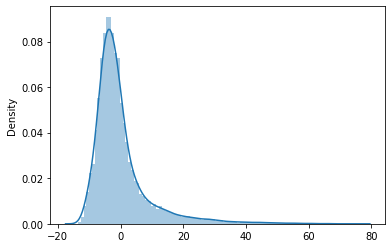

In [12]:
import seaborn as sns
import matplotlib as plt
y_train_flow = Reg.predict(x_train_lm)
sns.distplot((y_train - y_train_flow), bins = 100)

In [13]:
#Test[Test.columns.difference(['DateOrdinal'])] = scaler.fit_transform(Test[Test.columns.difference(['DateOrdinal'])])
#Test[Test.columns] = scaler.fit_transform(Test[Test.columns])
y_test = Test.pop('Flow')
x_test = Test

X_TEST = sm.add_constant(x_test)
X_TEST = X_TEST.drop(ListToDelete, axis = 1)
Y_PRED = Reg.predict(X_TEST)

In [14]:
y_test

7379      0.546378
10102     8.059473
8765      3.413386
4353      0.510046
1036     10.219372
           ...    
3523      7.083934
6117     11.827766
18519     2.998690
960       4.592728
18907     2.808006
Name: Flow, Length: 4018, dtype: float64

In [15]:
from sklearn.metrics import r2_score
r2_score(y_true = y_test, y_pred = Y_PRED)

0.12902377889484573

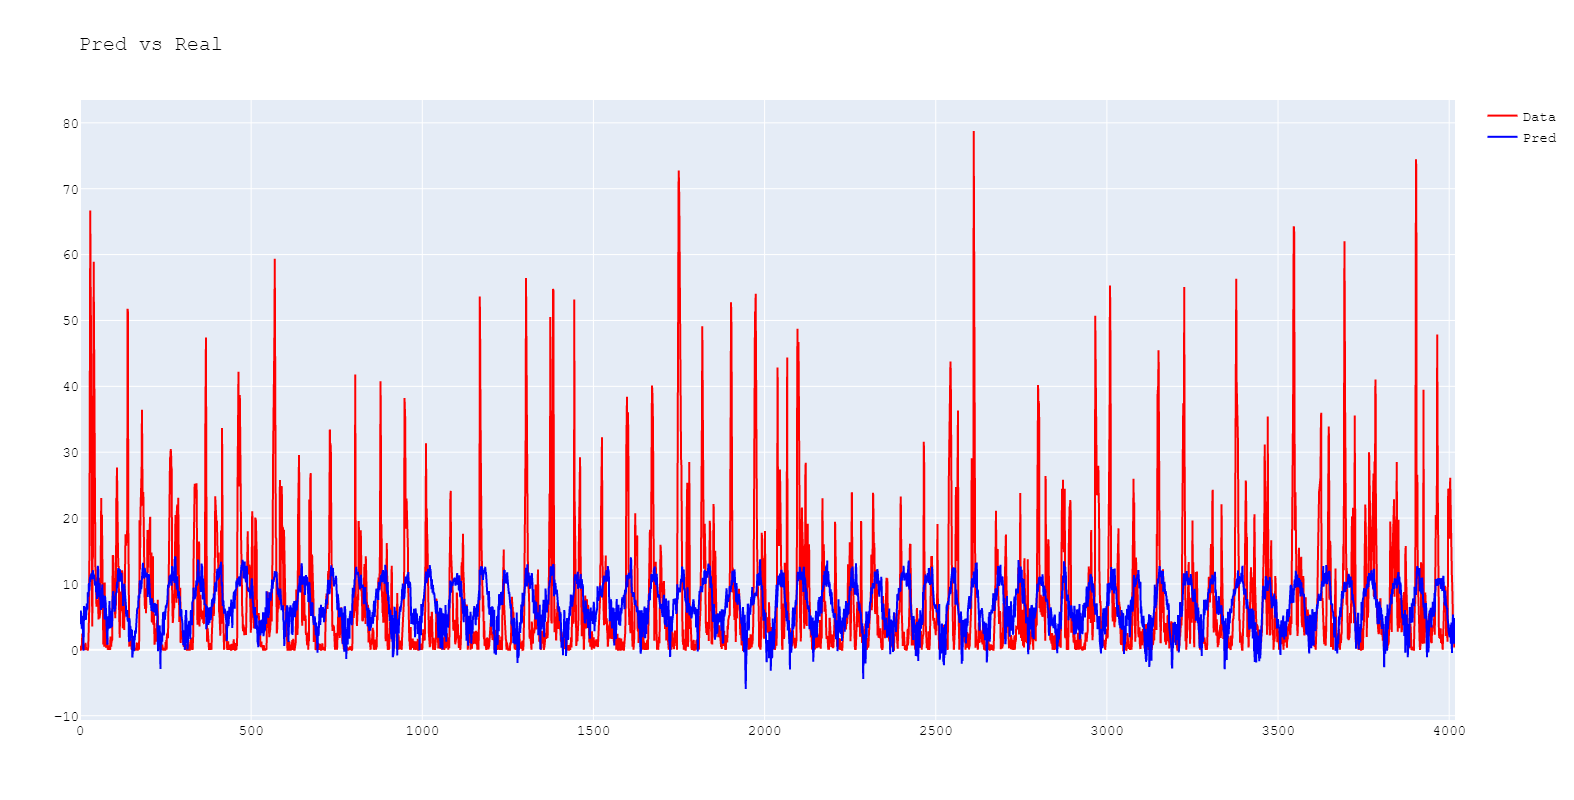

In [16]:
import plotly.offline as pyo
import plotly.graph_objs as go
from IPython.display import display, Markdown, Latex


ColumnsNames = list(dfTemp.columns)
ColumnsNames.remove('Date')
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=(y_test.sort_index()),
    name =  f'Data',
    mode = 'lines',
    line = dict(color = 'red'),
    connectgaps=False
    ),
 )


fig.add_trace(go.Scatter(
    y=(Y_PRED.sort_index()),
    name =  f'Pred',
    mode = 'lines',
    line = dict(color = 'Blue'),
    connectgaps=False
    ),
 )

fig.update_layout(
title=f'Pred vs Real',
font=dict(
family="Courier New, monospace",
size=14,
color="#000000"
))
    
fig.update_layout(height=800, width = 1100)

In [17]:
Reg.save("Model.pickle")
import statsmodels.api as sm
Reg = sm.load('Model.pickle')

In [18]:
Reg.predict()
FLOW_ND = Reg.predict(x_train_lm)

In [19]:
FLOW_ND

3458     11.831704
11959     6.538853
10344     7.806155
9615      9.520741
15326     4.637899
           ...    
17031     8.081406
806       6.996696
12846     4.971963
14874     4.973362
6367     11.656454
Length: 16068, dtype: float64

In [20]:
Df_Final['Flow'][8999]

1.5107630927297098

In [21]:
dat = Df_Final['Date'].apply(dt.datetime.toordinal)
Prec1 = Df_Final['Prec_Zone_1'][21176].tolist()
Temp8 = Df_Final['Temp_Zone_8'][21176].tolist()
DAT = dat[21176].tolist()
Lis = [Prec1,Temp8,DAT]
ListDF = pd.DataFrame({'const':1,'Prec_Zone_1':[Prec1],'Temp_Zone_8':[Temp8],'DateOrdinal':[DAT]})
#ListDF[ListDF.columns] = scaler.fit_transform(ListDF[ListDF.columns])
X_TEST = sm.add_constant(ListDF)


In [22]:
ListDF

const  Prec_Zone_1  Temp_Zone_8  DateOrdinal
0      1          0.0          4.0       735962

In [23]:
X_TEST

const  Prec_Zone_1  Temp_Zone_8  DateOrdinal
0      1          0.0          4.0       735962

In [39]:
############ Move date to use only month numbers


In [40]:
# now we can take a range of dates to star working on de prediction i will take from 1980 to 2014 
working_Df = Df_Final[(Df_Final['Date'] >= '2008-01-01') & (Df_Final['Date'] < '2015-01-01')]
print(min(working_Df['Date']), max(working_Df['Date']))

working_Df['Month'] = pd.DatetimeIndex(working_Df['Date']).month
working_Df.drop(['Date'], axis = 1, inplace = True)

#quick check for data 
print(working_Df.describe())
#Double check for null values and make sure the date value is in correct format 
print(working_Df.info())

2008-01-01 00:00:00 2014-12-31 00:00:00
       Prec_Zone_0  Prec_Zone_1  Prec_Zone_2  Prec_Zone_3  Prec_Zone_4  \
count  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000   
mean      2.220063     2.236488     2.137700     2.412867     2.411732   
std       4.556134     4.861423     4.721093     5.140568     5.306730   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       2.400000     2.200000     1.900000     2.400000     2.400000   
max      42.000000    41.099998    47.400002    48.099998    47.700001   

       Prec_Zone_5  Prec_Zone_6  Prec_Zone_7  Prec_Zone_8  Temp_Zone_0  \
count  2557.000000  2557.000000  2557.000000  2557.000000  2557.000000   
mean      2.416425     2.471568     2.595346     2.441924    -0.466015   
std       5.489465     5.227245     5.905653     5.560054     8.315498 

<ipython-input-40-ba8b43a3912f>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4162: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [41]:
#now we import sklearn
from sklearn.model_selection import train_test_split
#we will split the data 80% for training and the other 20% is for test
np.random.seed(0)
Train, Test = train_test_split(working_Df, train_size = 0.8, test_size = 0.2, random_state = 100)
#scaler to bring al variables to similar values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#Train[Train.columns.difference(['DateOrdinal'])] = scaler.fit_transform(Train[Train.columns.difference(['DateOrdinal'])])
Train[Train.columns] = scaler.fit_transform(Train[Train.columns])
y_train = Train.pop('Flow')
x_train = Train

<ipython-input-41-4c809035919f>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
import statsmodels.api as sm
x_train_lm = sm.add_constant(x_train)
Reg = sm.OLS(y_train,x_train_lm).fit()
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   Flow   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     22.02
Date:                Sat, 27 Mar 2021   Prob (F-statistic):           2.48e-69
Time:                        19:56:30   Log-Likelihood:                 1488.7
No. Observations:                2045   AIC:                            -2937.
Df Residuals:                    2025   BIC:                            -2825.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0842      0.011     -7.594      

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
VIF = pd.DataFrame()
VIF['Var'] = x_train.columns
VIF['VIF'] = [variance_inflation_factor(x_train.values,i)for i in range(x_train.shape[1])]
VIF = VIF.sort_values(by='VIF',ascending = False)
VIF

Var         VIF
16  Temp_Zone_7  420.580055
13  Temp_Zone_4  371.483120
15  Temp_Zone_6  360.361455
14  Temp_Zone_5  338.132319
10  Temp_Zone_1  309.103239
12  Temp_Zone_3  257.457764
11  Temp_Zone_2  232.373846
17  Temp_Zone_8  168.284558
9   Temp_Zone_0  132.378313
18        Month    2.685310
7   Prec_Zone_7    1.539244
6   Prec_Zone_6    1.513445
3   Prec_Zone_3    1.474976
1   Prec_Zone_1    1.464352
5   Prec_Zone_5    1.462625
4   Prec_Zone_4    1.455875
2   Prec_Zone_2    1.449659
0   Prec_Zone_0    1.415892
8   Prec_Zone_8    1.384815

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

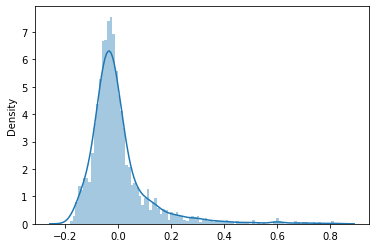

In [44]:
import seaborn as sns
import matplotlib as plt
y_train_flow = Reg.predict(x_train_lm)
sns.distplot((y_train - y_train_flow), bins = 100)

In [45]:
Test[Test.columns] = scaler.fit_transform(Test[Test.columns])
y_test = Test.pop('Flow')
x_test = Test

X_TEST = sm.add_constant(x_test)
#X_TEST = X_TEST.drop(ListToDelete, axis = 1)
Y_PRED = Reg.predict(X_TEST)
from sklearn.metrics import r2_score
print(r2_score(y_true = y_test, y_pred = Y_PRED))

0.167414443448487


<ipython-input-45-97131652e656>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



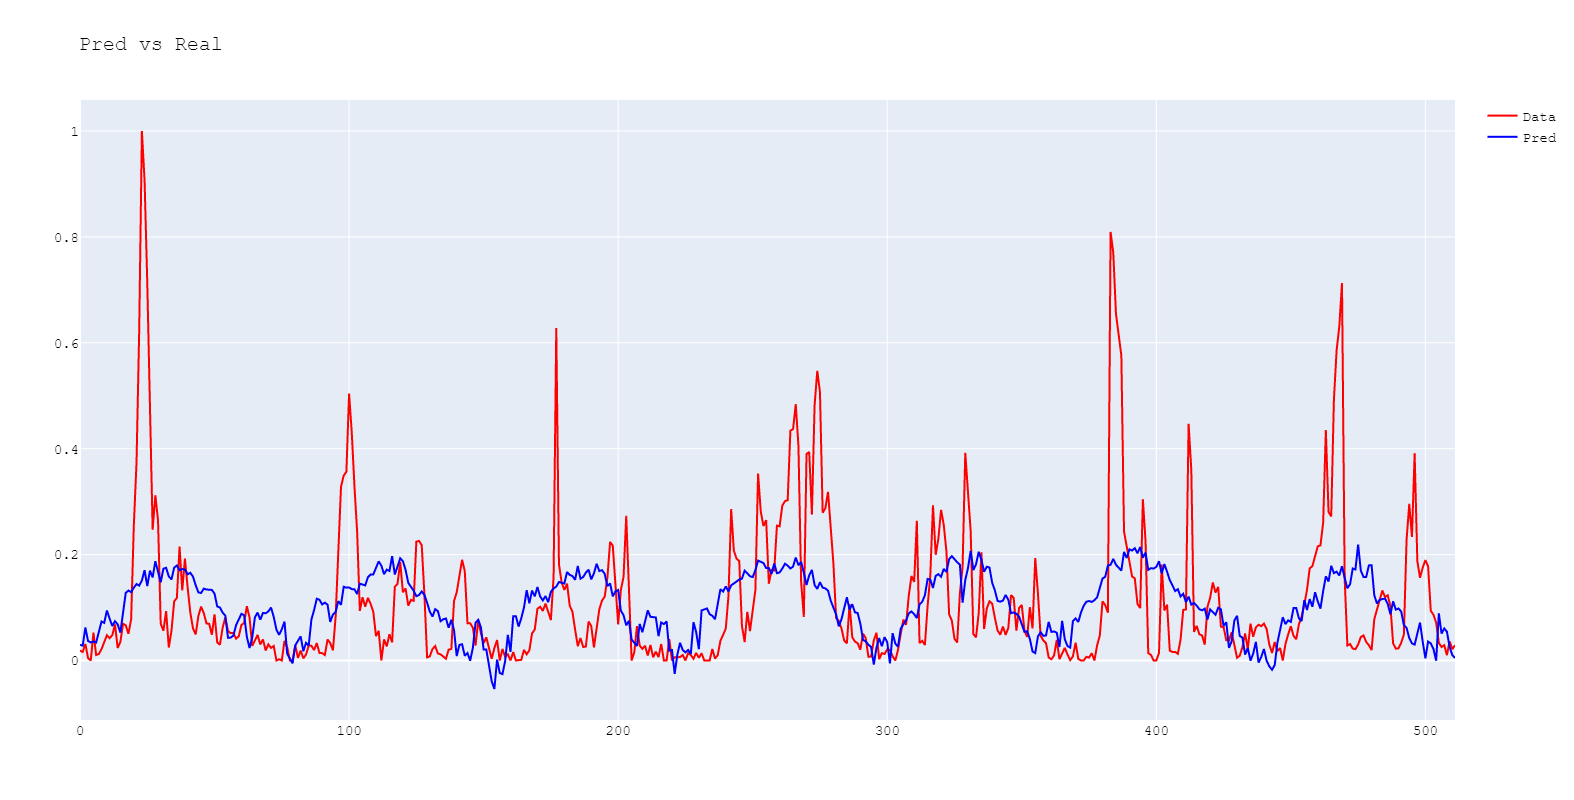

In [46]:
import plotly.offline as pyo
import plotly.graph_objs as go
from IPython.display import display, Markdown, Latex


ColumnsNames = list(dfTemp.columns)
ColumnsNames.remove('Date')
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=(y_test.sort_index()),
    name =  f'Data',
    mode = 'lines',
    line = dict(color = 'red'),
    connectgaps=False
    ),
 )


fig.add_trace(go.Scatter(
    y=(Y_PRED.sort_index()),
    name =  f'Pred',
    mode = 'lines',
    line = dict(color = 'Blue'),
    connectgaps=False
    ),
 )

fig.update_layout(
title=f'Pred vs Real',
font=dict(
family="Courier New, monospace",
size=14,
color="#000000"
))
    
fig.update_layout(height=800, width = 1100)

In [47]:
ListToDelete = list([
'Temp_Zone_1',
'Temp_Zone_2',
'Temp_Zone_3',
'Temp_Zone_4',
'Temp_Zone_5',   
'Temp_Zone_7',
'Temp_Zone_6',
'Prec_Zone_0',
'Prec_Zone_2',
'Prec_Zone_3',
'Prec_Zone_5',
'Prec_Zone_7',
])

# ListToDelete = list(['Temp_Zone_0',
#                      'Temp_Zone_1',
#                      'Temp_Zone_2',
#                      'Temp_Zone_3',
#                      'Temp_Zone_4',
#                      'Temp_Zone_5',
#                      'Temp_Zone_6',
#                      'Temp_Zone_7',
                     
#                      'Prec_Zone_0',
#                      'Prec_Zone_1',
#                      'Prec_Zone_2',
#                      'Prec_Zone_3',
#                      'Prec_Zone_4',
#                      'Prec_Zone_5',
#                      'Prec_Zone_6',
#                      'Prec_Zone_7',
#                      'Prec_Zone_8'])

In [48]:
X = x_train.drop(ListToDelete,axis = 1)
x_train_lm = sm.add_constant(X)
Reg = sm.OLS(y_train, x_train_lm).fit()
print(Reg.summary())

                            OLS Regression Results                            
Dep. Variable:                   Flow   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     58.32
Date:                Sat, 27 Mar 2021   Prob (F-statistic):           1.84e-76
Time:                        19:56:31   Log-Likelihood:                 1483.4
No. Observations:                2045   AIC:                            -2951.
Df Residuals:                    2037   BIC:                            -2906.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0822      0.010     -7.893      

In [49]:
VIF = pd.DataFrame()
VIF['Var'] = X.columns
VIF['VIF'] = [variance_inflation_factor(X.values,i)for i in range(X.shape[1])]
VIF = VIF.sort_values(by='VIF',ascending = False)
VIF

Var        VIF
5  Temp_Zone_8  23.695347
4  Temp_Zone_0  22.904975
6        Month   2.561804
2  Prec_Zone_6   1.316037
1  Prec_Zone_4   1.272936
3  Prec_Zone_8   1.262414
0  Prec_Zone_1   1.260244

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

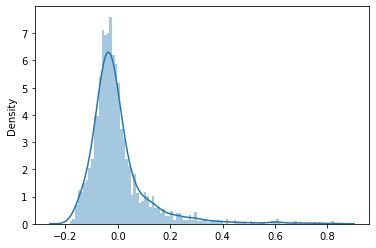

In [50]:
y_train_flow = Reg.predict(x_train_lm)
sns.distplot((y_train - y_train_flow), bins = 100)

In [51]:
#Test[Test.columns.difference(['DateOrdinal'])] = scaler.fit_transform(Test[Test.columns.difference(['DateOrdinal'])])
#Test[Test.columns] = scaler.fit_transform(Test[Test.columns])
#y_test = Test.pop('Flow')
x_test = Test

X_TEST = sm.add_constant(x_test)
X_TEST = X_TEST.drop(ListToDelete, axis = 1)
Y_PRED = Reg.predict(X_TEST)
from sklearn.metrics import r2_score
print(r2_score(y_true = y_test, y_pred = Y_PRED))

0.1658488038738266


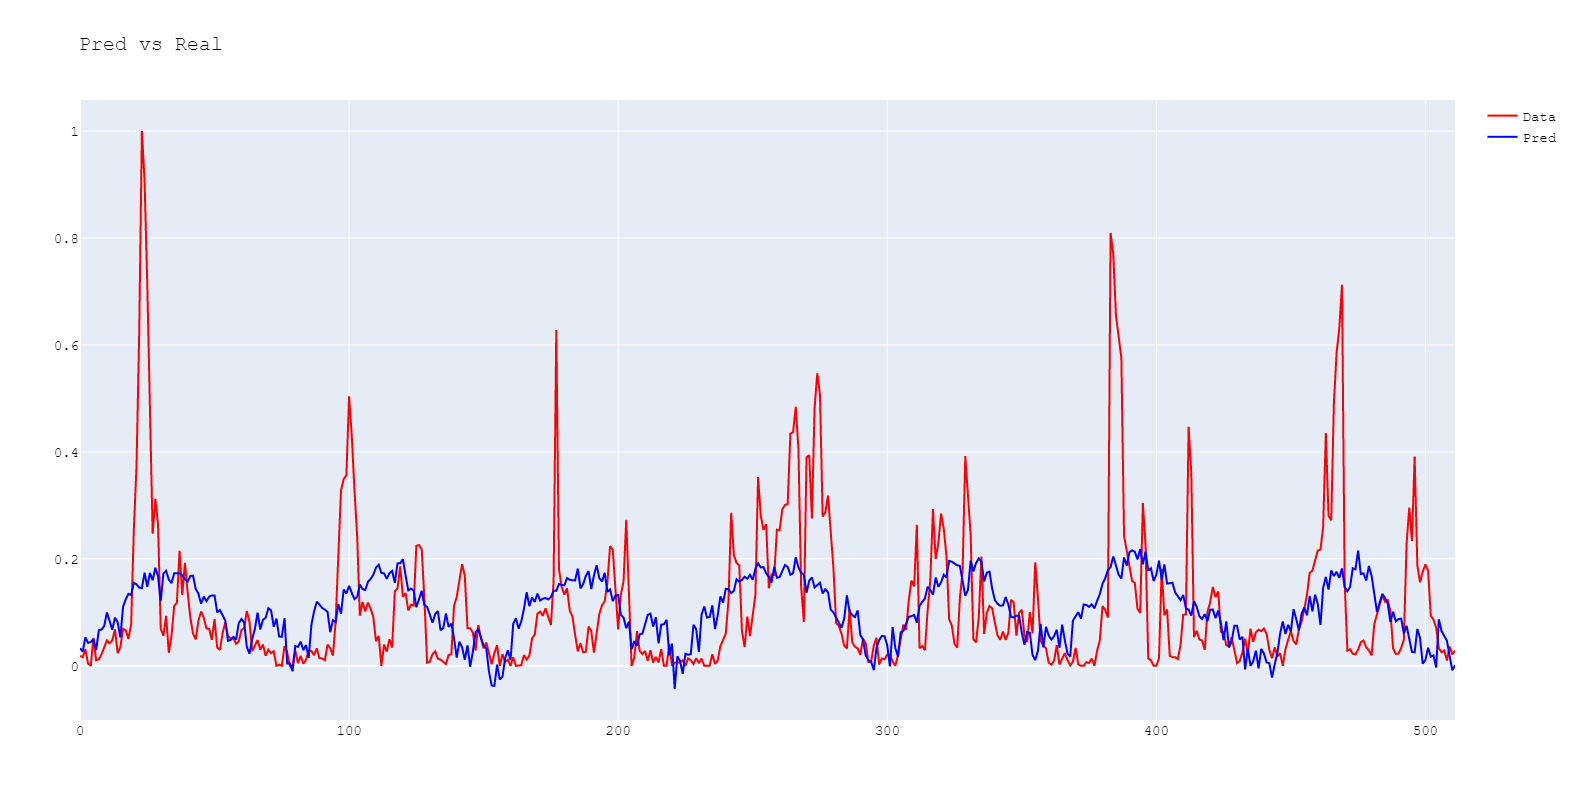

In [52]:
import plotly.offline as pyo
import plotly.graph_objs as go
from IPython.display import display, Markdown, Latex


ColumnsNames = list(dfTemp.columns)
ColumnsNames.remove('Date')
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=(y_test.sort_index()),
    name =  f'Data',
    mode = 'lines',
    line = dict(color = 'red'),
    connectgaps=False
    ),
 )


fig.add_trace(go.Scatter(
    y=(Y_PRED.sort_index()),
    name =  f'Pred',
    mode = 'lines',
    line = dict(color = 'Blue'),
    connectgaps=False
    ),
 )

fig.update_layout(
title=f'Pred vs Real',
font=dict(
family="Courier New, monospace",
size=14,
color="#000000"
))
    
fig.update_layout(height=800, width = 1100)

# Tests

In [53]:
y_FLOW_Pred = Reg.predict(X_TEST)


In [54]:
y_FLOW_Pred

20544    0.130605
19079    0.127791
19444    0.144012
18618    0.089182
20433   -0.006603
           ...   
20238    0.212414
20644    0.171578
18359    0.134636
19061    0.137634
20187    0.133994
Length: 512, dtype: float64

In [55]:
Train[Train.columns.difference(['DateOrdinal'])] = scaler.fit_transform(Train[Train.columns.difference(['DateOrdinal'])])

<ipython-input-55-3086b5ac2ca2>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3072: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\users\dany_\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3037: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [56]:
Train.columns.difference(['DateOrdinal'])

Index(['Month', 'Prec_Zone_0', 'Prec_Zone_1', 'Prec_Zone_2', 'Prec_Zone_3',
       'Prec_Zone_4', 'Prec_Zone_5', 'Prec_Zone_6', 'Prec_Zone_7',
       'Prec_Zone_8', 'Temp_Zone_0', 'Temp_Zone_1', 'Temp_Zone_2',
       'Temp_Zone_3', 'Temp_Zone_4', 'Temp_Zone_5', 'Temp_Zone_6',
       'Temp_Zone_7', 'Temp_Zone_8'],
      dtype='object')

In [57]:
Train

Prec_Zone_0  Prec_Zone_1  Prec_Zone_2  Prec_Zone_3  Prec_Zone_4  \
19363     0.000000     0.000000     0.006329     0.000000     0.000000   
19579     0.000000     0.002433     0.056962     0.000000     0.000000   
20592     0.088095     0.000000     0.000000     0.000000     0.253669   
20232     0.000000     0.000000     0.000000     0.000000     0.000000   
18592     0.000000     0.000000     0.090717     0.031185     0.000000   
...            ...          ...          ...          ...          ...   
18606     0.000000     0.000000     0.000000     0.000000     0.000000   
20186     0.000000     0.000000     0.006329     0.000000     0.004193   
18335     0.259524     0.384428     0.371308     0.081081     0.000000   
20115     0.000000     0.114355     0.126582     0.045738     0.215933   
19800     0.142857     0.542579     0.202532     0.045738     0.060797   

       Prec_Zone_5  Prec_Zone_6  Prec_Zone_7  Prec_Zone_8  Temp_Zone_0  \
19363     0.000000     0.000000     0.000000     0.115332     0.619266   
19579     0.000000     0.000000     0.000000     0.037992     0.756881   
20592     0.039182     0.078029     0.078740     0.020353     0.690367   
20232     0.000000     0.000000     0.000000     0.014925     0.855505   
18592     0.000000     0.000000     0.000000     0.000000     0.552752   
...            ...          ...          ...          ...          ...   
18606     0.000000     0.000000     0.000000     0.000000     0.247706   
20186     0.000000     0.000000     0.000000     0.130258     0.756881   
18335     0.000000     0.030801     0.000000     0.000000     0.589450   
20115     0.567291     0.112936     0.233071     0.035278     0.394495   
19800     0.093697     0.000000     0.000000     0.000000     0.600917   

       Temp_Zone_1  Temp_Zone_2  Temp_Zone_3  Temp_Zone_4  Temp_Zone_5  \
19363     0.567442     0.423581     0.159041     0.347921     0.433790   
19579     0.795349     0.692140     0.675381     0.730853     0.755708   
20592     0.762791     0.827511     0.795207     0.776805     0.819635   
20232     0.897674     0.871179     0.830065     0.776805     0.821918   
18592     0.497674     0.443231     0.455338     0.487965     0.465753   
...            ...          ...          ...          ...          ...   
18606     0.302326     0.179039     0.250545     0.501094     0.488584   
20186     0.797674     0.735808     0.638344     0.610503     0.616438   
18335     0.595349     0.587336     0.551198     0.536105     0.518265   
20115     0.483721     0.545852     0.520697     0.512035     0.495434   
19800     0.641860     0.631004     0.557734     0.536105     0.550228   

       Temp_Zone_6  Temp_Zone_7  Temp_Zone_8     Month  
19363     0.334071     0.218543     0.339326  0.000000  
19579     0.719027     0.708609     0.698876  0.636364  
20592     0.785398     0.812362     0.797753  0.363636  
20232     0.827434     0.860927     0.903371  0.363636  
18592     0.411504     0.339956     0.307865  1.000000  
...            ...          ...          ...       ...  
18606     0.550885     0.520971     0.492135  1.000000  
20186     0.590708     0.598234     0.600000  0.272727  
18335     0.528761     0.622517     0.669663  0.181818  
20115     0.457965     0.368653     0.355056  0.090909  
19800     0.595133     0.520971     0.485393  0.181818  

[2045 rows x 19 columns]

In [58]:
Df_Final['Flow'][21165:21175]

21165    0.775858
21166    1.746223
21167    2.309434
21168    4.281342
21169    3.734578
21170    1.921873
21171    5.067260
21172    2.177040
21173    4.876250
21174    4.998840
Name: Flow, dtype: float64

In [59]:
print(Df_Final['Prec_Zone_1'][21176])
print(Df_Final['Temp_Zone_8'][21176])
print(Df_Final['Flow'][21176])

0.0
4.0
4.047924586852257


In [60]:
Df_Final[21176]

KeyError: 21176

In [ ]:
#since we have each dataframe from temps an prec we can easily plot the data to make it easy to visualize
import plotly.offline as pyo
import plotly.graph_objs as go
from IPython.display import display, Markdown, Latex

In [ ]:
# Create a trace for each one of the different zones 
#Df_Final
from faker import Factory
fake = Factory.create()


ColumnsNames = list(Df_Final.columns)
ColumnsNames.remove('Date')
fig = go.Figure()
for i in ColumnsNames:
    fig.add_trace(go.Scatter(
        x=(Df_Final['Date']),
        y=(Df_Final[i]),
        name =  f'{i}',
        mode = 'lines',
        line = dict(color = fake.hex_color()),
        connectgaps=False
        ),
     )

fig.update_layout(
    title=f'Temp',
    font=dict(
    family="Courier New, monospace",
    size=14,
    color="#000000"
    ))
    
fig.update_layout(height=800, width = 1100)


In [ ]:
Df_Final.to_csv('DataFrame.csv',index = False)